In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.optim import lr_scheduler
import torch.optim as optim
import os
from torchvision import transforms
# Set up the network and training parameters
from networks import EmbeddingNet, ClassificationNet, ModelM3

import wandb
import numpy as np
from embeddings_utils import generate_embeddings, extract_embeddings
from MITSplitDataSet import MITSplitDataSet
from trainer import train, test

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5, 0.5, 0.5],
    #                      std=[0.5, 0.5, 0.5] ) 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #For imagenet pretrained
])
# TRAIN_DATA_PATH = '../MIT_split/train_images_filenames.dat'
# TRAIN_LABELS_DATA_PATH = '../MIT_split/train_labels.dat'
TRAIN_DATA_PATH = "../MIT_split/train/"
TEST_DATA_PATH = "../MIT_split/test/"

batch_size = 64

TRANSFORM_IMG = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4275, 0.4525, 0.4494],
                         std=[0.2566, 0.2470, 0.2764])
    ])

train_data = ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
test_data = ImageFolder(root=TEST_DATA_PATH, transform=TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, **kwargs)


In [3]:
n_classes = 8
mit_classes = ['coast', 'forest', 'highway', 'inside_city', 'mountain',
                         'Opencountry', 'street', 'tallbuilding']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',]

embedding_net = ModelM3()
model = ClassificationNet(embedding_net, n_classes).to(device)

In [4]:
save_path = 'first_WEEK_model_trained2.pth'
if not os.path.exists(save_path):
    loss_fn = torch.nn.CrossEntropyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for t in range(50):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_acc = test(test_loader, model, loss_fn)
    torch.save(model.state_dict(), save_path)
else:
    model.load_state_dict(torch.load(save_path))
    model.to(device)

Epoch 1
-------------------------------


Training loss: 1.903983, Training accuracy: 0.283892
Test Error: Accuracy: 35.7%, Avg loss: 1.658233
Epoch 2
-------------------------------


Training loss: 1.544051, Training accuracy: 0.436470
Test Error: Accuracy: 55.3%, Avg loss: 1.339287
Epoch 3
-------------------------------


Training loss: 1.330905, Training accuracy: 0.522594
Test Error: Accuracy: 57.0%, Avg loss: 1.174724
Epoch 4
-------------------------------


Training loss: 1.187909, Training accuracy: 0.580011
Test Error: Accuracy: 60.8%, Avg loss: 1.111182
Epoch 5
-------------------------------


Training loss: 1.104007, Training accuracy: 0.603934
Test Error: Accuracy: 68.0%, Avg loss: 0.994130
Epoch 6
-------------------------------


Training loss: 1.031157, Training accuracy: 0.638490
Test Error: Accuracy: 69.6%, Avg loss: 0.911199
Epoch 7
-------------------------------


Training loss: 0.957925, Training accuracy: 0.673578
Test Error: Accuracy: 72.5%, Avg loss: 0.837207
Epoch 8
-------------------------------


Training loss: 0.875982, Training accuracy: 0.705476
Test Error: Accuracy: 71.4%, Avg loss: 0.832653
Epoch 9
-------------------------------


Training loss: 0.833586, Training accuracy: 0.711855
Test Error: Accuracy: 75.8%, Avg loss: 0.731535
Epoch 10
-------------------------------


Training loss: 0.753918, Training accuracy: 0.747475
Test Error: Accuracy: 78.1%, Avg loss: 0.691110
Epoch 11
-------------------------------


Training loss: 0.696477, Training accuracy: 0.769803
Test Error: Accuracy: 75.7%, Avg loss: 0.681790
Epoch 12
-------------------------------


Training loss: 0.647400, Training accuracy: 0.774588
Test Error: Accuracy: 77.9%, Avg loss: 0.620043
Epoch 13
-------------------------------


Training loss: 0.624077, Training accuracy: 0.783094
Test Error: Accuracy: 79.9%, Avg loss: 0.581025
Epoch 14
-------------------------------


Training loss: 0.610920, Training accuracy: 0.779373
Test Error: Accuracy: 79.6%, Avg loss: 0.593114
Epoch 15
-------------------------------


Training loss: 0.603511, Training accuracy: 0.800106
Test Error: Accuracy: 79.3%, Avg loss: 0.573114
Epoch 16
-------------------------------


Training loss: 0.592525, Training accuracy: 0.801701
Test Error: Accuracy: 81.7%, Avg loss: 0.545001
Epoch 17
-------------------------------


Training loss: 0.536582, Training accuracy: 0.814460
Test Error: Accuracy: 80.7%, Avg loss: 0.554334
Epoch 18
-------------------------------


Training loss: 0.515530, Training accuracy: 0.829878
Test Error: Accuracy: 80.4%, Avg loss: 0.562085
Epoch 19
-------------------------------


Training loss: 0.535777, Training accuracy: 0.819245
Test Error: Accuracy: 81.5%, Avg loss: 0.510237
Epoch 20
-------------------------------


Training loss: 0.508334, Training accuracy: 0.819245
Test Error: Accuracy: 78.7%, Avg loss: 0.596516
Epoch 21
-------------------------------


Training loss: 0.509101, Training accuracy: 0.824561
Test Error: Accuracy: 81.8%, Avg loss: 0.511530
Epoch 22
-------------------------------


Training loss: 0.504155, Training accuracy: 0.822967
Test Error: Accuracy: 82.9%, Avg loss: 0.479017
Epoch 23
-------------------------------


Training loss: 0.461668, Training accuracy: 0.835194
Test Error: Accuracy: 81.3%, Avg loss: 0.550648
Epoch 24
-------------------------------


Training loss: 0.474148, Training accuracy: 0.839447
Test Error: Accuracy: 82.7%, Avg loss: 0.530430
Epoch 25
-------------------------------


Training loss: 0.442182, Training accuracy: 0.847422
Test Error: Accuracy: 83.3%, Avg loss: 0.467723
Epoch 26
-------------------------------


Training loss: 0.451245, Training accuracy: 0.842105
Test Error: Accuracy: 82.9%, Avg loss: 0.501709
Epoch 27
-------------------------------


Training loss: 0.418831, Training accuracy: 0.851143
Test Error: Accuracy: 84.9%, Avg loss: 0.437151
Epoch 28
-------------------------------


Training loss: 0.422020, Training accuracy: 0.858054
Test Error: Accuracy: 84.9%, Avg loss: 0.459865
Epoch 29
-------------------------------


Training loss: 0.447155, Training accuracy: 0.846358
Test Error: Accuracy: 83.3%, Avg loss: 0.467595
Epoch 30
-------------------------------


Training loss: 0.459563, Training accuracy: 0.834131
Test Error: Accuracy: 82.5%, Avg loss: 0.490367
Epoch 31
-------------------------------


Training loss: 0.410376, Training accuracy: 0.856991
Test Error: Accuracy: 83.6%, Avg loss: 0.460538
Epoch 32
-------------------------------


Training loss: 0.397898, Training accuracy: 0.860181
Test Error: Accuracy: 85.3%, Avg loss: 0.434656
Epoch 33
-------------------------------


Training loss: 0.408480, Training accuracy: 0.858054
Test Error: Accuracy: 85.1%, Avg loss: 0.447367
Epoch 34
-------------------------------


Training loss: 0.393930, Training accuracy: 0.871345
Test Error: Accuracy: 84.1%, Avg loss: 0.491768
Epoch 35
-------------------------------


Training loss: 0.410600, Training accuracy: 0.856459
Test Error: Accuracy: 84.5%, Avg loss: 0.456270
Epoch 36
-------------------------------


Training loss: 0.392429, Training accuracy: 0.861244
Test Error: Accuracy: 85.3%, Avg loss: 0.446574
Epoch 37
-------------------------------


Training loss: 0.370812, Training accuracy: 0.869750
Test Error: Accuracy: 84.3%, Avg loss: 0.447885
Epoch 38
-------------------------------


Training loss: 0.395004, Training accuracy: 0.867092
Test Error: Accuracy: 86.4%, Avg loss: 0.439896
Epoch 39
-------------------------------


Training loss: 0.367852, Training accuracy: 0.874535
Test Error: Accuracy: 86.1%, Avg loss: 0.409680
Epoch 40
-------------------------------


Training loss: 0.353098, Training accuracy: 0.876130
Test Error: Accuracy: 87.1%, Avg loss: 0.413238
Epoch 41
-------------------------------


Training loss: 0.343875, Training accuracy: 0.885699
Test Error: Accuracy: 86.0%, Avg loss: 0.427489
Epoch 42
-------------------------------


Training loss: 0.352385, Training accuracy: 0.879851
Test Error: Accuracy: 84.9%, Avg loss: 0.427638
Epoch 43
-------------------------------


Training loss: 0.358243, Training accuracy: 0.876661
Test Error: Accuracy: 86.7%, Avg loss: 0.417424
Epoch 44
-------------------------------


Training loss: 0.336943, Training accuracy: 0.885167
Test Error: Accuracy: 87.0%, Avg loss: 0.384021
Epoch 45
-------------------------------


Training loss: 0.329465, Training accuracy: 0.881446
Test Error: Accuracy: 86.9%, Avg loss: 0.400657
Epoch 46
-------------------------------


Training loss: 0.334139, Training accuracy: 0.880383
Test Error: Accuracy: 85.9%, Avg loss: 0.413224
Epoch 47
-------------------------------


Training loss: 0.316719, Training accuracy: 0.884104
Test Error: Accuracy: 85.6%, Avg loss: 0.409305
Epoch 48
-------------------------------


Training loss: 0.303394, Training accuracy: 0.892079
Test Error: Accuracy: 88.1%, Avg loss: 0.391028
Epoch 49
-------------------------------


Training loss: 0.322787, Training accuracy: 0.894205
Test Error: Accuracy: 87.2%, Avg loss: 0.384118
Epoch 50
-------------------------------


Training loss: 0.289319, Training accuracy: 0.892610
Test Error: Accuracy: 88.0%, Avg loss: 0.364770


In [5]:
# generate_embeddings(model, TRANSFORM_IMG, '../MIT_split/train', 'embs_m3Net.pkl')
embs, labels = extract_embeddings(train_loader, model, 256)

In [6]:
from matplotlib import pyplot as plt

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(8):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mit_classes)

In [7]:
TRAIN_PATH = '../MIT_split/train_images_filenames.dat'
TRAIN_LABELS_DATA_PATH = '../MIT_split/train_labels.dat'
train_data2 = MITSplitDataSet(TRAIN_PATH, TRAIN_LABELS_DATA_PATH, TRANSFORM_IMG)

cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader2 = DataLoader(train_data2, batch_size=64, shuffle=True, **kwargs)


In [8]:
def extract_embeddings2(dataloader, model, size):
    with torch.no_grad():
        model.eval()
        all_ = []
        embeddings = np.zeros((len(dataloader.dataset), size))
        labels = np.zeros(len(dataloader.dataset))
        paths = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target, paths in dataloader:
            images = images.to(device)
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            embs_aux = model.get_embedding(images).data.cpu().numpy()
            # labels[k:k+len(images)] = target
            for ind in range(len(images)):
                all_.append({'path': paths[ind], 'emb': embs_aux[ind], 'label': target[ind]})
            k += len(images)
    return embeddings, labels, all_

_,_, aux = extract_embeddings2(train_loader2, model, 256)


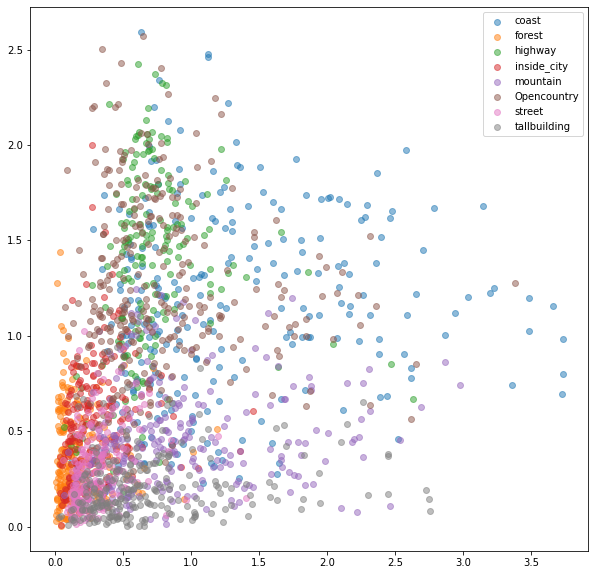

In [12]:
dict_mit_classes = {
    'coast': 0.,
    'forest': 1.,
    'highway': 2.,
    'inside_city': 3.,
    'mountain': 4.,
    'Opencountry': 5.,
    'street': 6.,
    'tallbuilding': 7.

}
labels2 = [dict_mit_classes[f['label']] for f in aux]
embs2 = [f['emb'] for f in aux]

plot_embeddings(np.array(embs2), np.array(labels2))

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
components = pca.fit_transform(embs)



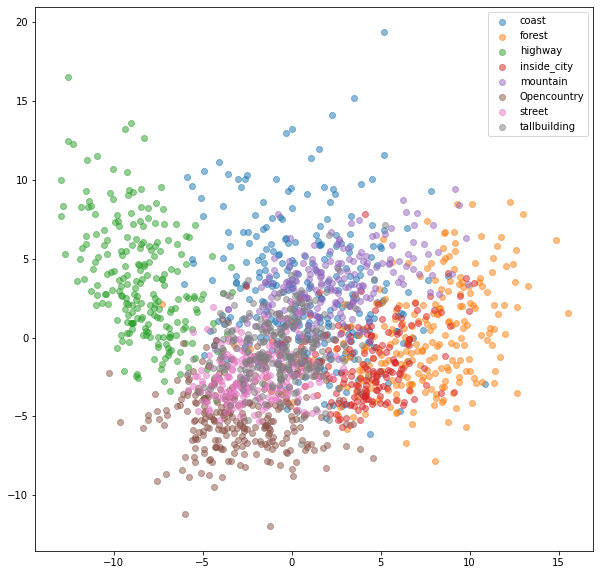

In [11]:
plot_embeddings(components[:,1:], labels)

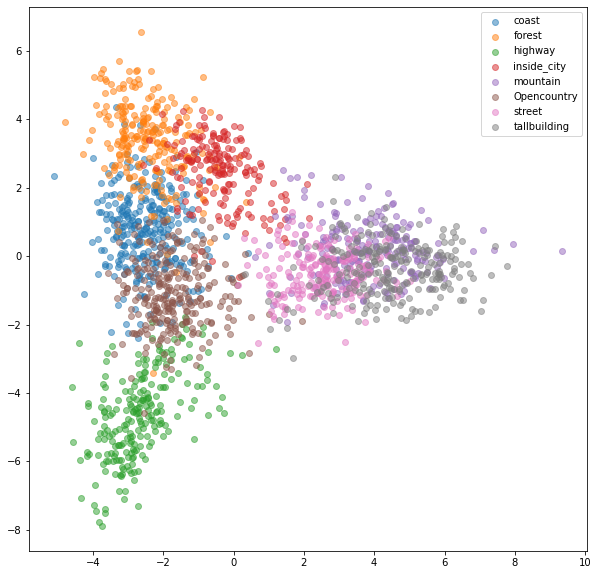

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda_embs = lda.fit_transform(embs, labels)

plot_embeddings(lda_embs,labels)

In [13]:
from sklearn.neighbors import KNeighborsClassifier
def build_knn(train_data, train_labels, n, distance='euclidean'):
  knn = KNeighborsClassifier(n_neighbors=n,n_jobs=-1,metric=distance)
  knn.fit(train_data, train_labels)
  return knn

embs_test, labels_test = extract_embeddings(test_loader, model, 256)

knn = build_knn(embs, labels, n_classes)
print(100.0 * knn.score(embs_test,labels_test))

86.74101610904586


In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

Y = label_binarize(labels, classes=[*range(n_classes)])
Y_test = label_binarize(labels_test, classes=[*range(n_classes)])

clf = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=100))
clf.fit(embs, Y)

y_score = clf.predict_proba(embs_test)

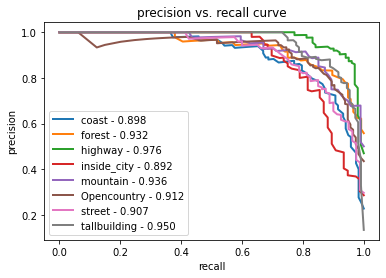

In [25]:
# precision recall curve
precision = dict()
recall = dict()
for i in range(n_classes):
    ap = average_precision_score(Y_test[:, i], y_score[:, i])
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i],
                                                        y_score[:, i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{mit_classes[i]} - {ap:.3f}')
    
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.show()

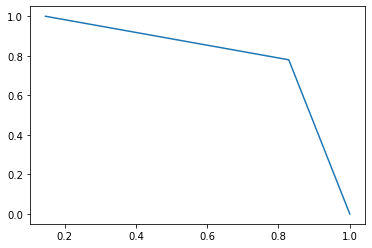

In [19]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
predictions = knn.predict(embs_test)
for cl in range(n_classes):
    labels_aux = labels_test == cl
    predicts_aux = predictions == cl
    precision, recall, thresholds = precision_recall_curve(labels_aux, predicts_aux)
    # knn_aux = build_knn(embs, labels_aux, 2)
    # display = PrecisionRecallDisplay.from_estimator(
    #     knn_aux, embs_test, labels_test, name="KNN"
    # )
    plt.plot(precision, recall)
    plt.show()
    break

    # _ = display.ax_.set_title("8-class Precision-Recall curve")
